<a href="https://colab.research.google.com/github/MrCoeg/Skripsi/blob/main/Experiment_3/Tunning%20Neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Menghubungkan ke Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import gdown
file_id = "1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB
To: /content/Dataset.zip
100%|██████████| 390M/390M [00:01<00:00, 199MB/s]


'Dataset.zip'

In [3]:
!unzip 'Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/rgb/00037591.jpg  
  inflating: Dataset/rgb/00037538.jpg  
  inflating: Dataset/rgb/00037543.jpg  
  inflating: Dataset/rgb/00037547.jpg  
  inflating: Dataset/rgb/00037553.jpg  
  inflating: Dataset/rgb/00037563.jpg  
  inflating: Dataset/rgb/00037549.jpg  
  inflating: Dataset/rgb/00037545.jpg  
  inflating: Dataset/rgb/00037558.jpg  
  inflating: Dataset/rgb/00037562.jpg  
  inflating: Dataset/rgb/00037511.jpg  
  inflating: Dataset/rgb/00037519.jpg  
  inflating: Dataset/rgb/00037542.jpg  
  inflating: Dataset/rgb/00037554.jpg  
  inflating: Dataset/rgb/00037552.jpg  
  inflating: Dataset/rgb/00037615.jpg  
  inflating: Dataset/rgb/00037548.jpg  
  inflating: Dataset/rgb/00037561.jpg  
  inflating: Dataset/rgb/00037555.jpg  
  inflating: Dataset/rgb/00037539.jpg  
  inflating: Dataset/rgb/00037512.jpg  
  inflating: Dataset/rgb/00037520.jpg  
  inflating: Dataset/rgb/00037541.jpg  
  inflating: Dataset/rgb/0003

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm

# Variabel Parameter Kontrol Program

# Index dari N-Keypoint yang dipilih
INDEX_KEYPOINTS = [0, 4, 8, 12, 16, 20]
N_KEYPOINTS = 6

# Channel warna pada input image
N_IMG_CHANNELS = 3
# Size Image setelah tahap preprocesing resize
MODEL_IMG_SIZE = 128

RAW_IMG_SIZE = 224

# Property dari mean dan stds dataset untuk normalisasi
# Nilai didapat menggunakan get_norm_params
DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

# Neuron model CNN
MODEL_NEURONS = 32

# Blur Size
fg_size = 51
fgk_size = 5

# colormap untuk matplotlib
COLORMAP = {
    "thumb": {"ids": [0, 1], "color": "g"},
    "index": {"ids": [0, 2], "color": "c"},
    "middle": {"ids": [0, 3], "color": "b"},
    "ring": {"ids": [0, 4], "color": "m"},
    "little": {"ids": [0, 5], "color": "r"},
}

# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (fg_size, fg_size), fgk_size)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred

# Loss function IoU
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / 128

# Visualisasi sample data
def show_data(dataset, n_samples=4):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)
        plt.imshow(image)

        # mendapatkan heatmap image input
        heatmaps = sample["heatmaps"].numpy()

        # mengubah heatmap image input menjadi keypoint
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                input_keypoints[params["ids"], 0],
                input_keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 13000
            n_end = 13120

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),

            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        image_name = self.image_names[idx]

        # instance image menggunakan PIL
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()
        if 0 < flip_probability < 0.25:
          image = self.image_transform(image_raw)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image_raw)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  238240


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):

        # Preparation
        conv_re = self.conv_in(x)

        #Left-Low
        conv_d1 = self.conv_down1(self.maxpool(conv_re))
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))

        # Feature Mapping
        conv_b = self.conv_bottleneck(conv_d4)

        #
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237664


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237664


In [8]:
import torch
import torch.nn as nn

class ResiudalBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
        )

    def forward(self, x):
        residual = self.double_conv(x);
        return residual + x


class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),

            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),


        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, low_channel, high_channel):
        super().__init__()

        self.skip_in = nn.Sequential(
            nn.Conv2d(low_channel, high_channel, kernel_size=3, stride=1, padding=1, bias=False)
        )

        self.up_in = nn.Sequential(
            nn.Conv2d(high_channel, high_channel, kernel_size=3, stride=1, padding=1, bias=False),
        )

        self.attention = nn.Sequential(
            nn.BatchNorm2d(high_channel),
            nn.ReLU(inplace= True),
            nn.Conv2d(high_channel, 1, kernel_size=1, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
    def forward(self, x, g):
        spatial_x = self.skip_in(x)
        g = self.up_in(g)
        cat_1 = torch.add(g, spatial_x)
        attention = self.attention(cat_1)
        cat_2 = torch.multiply(x, attention)
        return cat_2


class DepthwiseResidualUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.skip_1 = ResiudalBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.attention_1 = AttentionBlock(MODEL_NEURONS, MODEL_NEURONS * 2)

        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.skip_2 = ResiudalBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 2)
        self.attention_2 = AttentionBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)

        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.skip_3 = ResiudalBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 4)
        self.attention_3 = AttentionBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)


        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        skip_d11 = self.skip_1(conv_d1)
        skip_d12 = self.skip_1(skip_d11)

        pool1 = self.maxpool(conv_d1)
        conv_d2 = self.conv_down2(pool1)
        skip_d21 = self.skip_2(conv_d2)
        skip_d22 = self.skip_2(skip_d21)


        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        skip_d31 = self.skip_3(conv_d3)
        skip_d32 = self.skip_3(skip_d31)

        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))
        up_1 = self.upsample(conv_b)


        attention_3 = self.attention_3(skip_d32, up_1)
        conv_u1 = self.conv_up1(torch.cat([up_1, attention_3], dim=1))

        up_2 = self.upsample(conv_u1)
        attention_2 = self.attention_2(skip_d22, up_2)

        conv_u2 = self.conv_up2(torch.cat([up_2, attention_2], dim=1))

        up_3 = self.upsample(conv_u2)
        attention_1 = self.attention_1(skip_d12, up_3)
        conv_u3 = self.conv_up3(torch.cat([up_3, attention_1], dim=1))

        out = self.conv_out(conv_u3)
        return out

depthwise_model = DepthwiseResidualUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  1453638


In [ ]:
import torch
import torch.nn as nn
MODEL_NEURONS = 2
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        # membuat model block arsitektur U-Net
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # Membuat model U-Net sesuai dengan arsitektur pada slide presentasi

        # membuat ConvBlock Encoder dengan  3 Input Neuron dan output 16 Neuron
        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)

        # membuat ConvBlock Encoder dengan 16 Neuron dan output 32 Neuron
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)

        # membuat ConvBlock Encoder dengan 32 Neuron dan output 64 Neuron
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)

        # membuat ConvBlock Encoder dengan 64 Neuron dan output 128 Neuron
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # membuat layer maxpool2d 2x2
        self.maxpool = nn.MaxPool2d(2)

        # membuat layer updsample 2x2
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # membuat ConvBlock Decoder dengan 128 Neuron + 64 Neuron Concatination dan output 64 Neuron
        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )

        # membuat ConvBlock Decoder dengan 64 Neuron + 32 Neuron Concatination dan output 32 Neuron
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )

        # membuat ConvBlock Decoder dengan 32 Neuron + 16 Neuron Concatination dan output 16 Neuron
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        # membuat Output layer dengan 16 Neuron dan output N-Keypoint
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self):

        # Menyambungkan input image terhadap layer conv encoder 1
        conv_d1 = self.conv_down1(x)
        # Menyambungkan conv encoder 1 terhadap layer conv encoder 2 dengan down sampling
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        # Menyambungkan conv encoder 2 terhadap layer conv encoder 3 down sampling
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))

        # Menyambungkan conv encoder 3 terhadap layer bottleneck dengan down sampling
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        # Menyambungkan bottleneck  bersama conv encoder 3 dengan menggunakan concatination terhadap layer decoder 1 dengan up sampling
        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        # Menyambungkan decoder 1  bersama conv encoder 2 dengan menggunakan concatination terhadap layer decoder 2 dengan up sampling
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        # Menyambungkan decoder 2  bersama conv encoder 1 dengan menggunakan concatination terhadap layer decoder 3 dengan up sampling
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        # Menyambungkan layer decoder 3 dengan output layer
        out = self.conv_out(conv_u3)

        return 1 - torch.mean(torch.randn((1)))

input_shape = (1, 3, 224, 224)  # Batch size x Channels x Height x Width
input_tensor = torch.randn(input_shape)


normal_model = ShallowUNet(3,3)
depthwise_parameter = sum(p.numel() for p in normal_model.parameters() if p.requires_grad)
print(f'Normal Model Parameter : ', depthwise_parameter)

Normal Model Parameter :  7910


In [7]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            print(self.optimizer)

            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            labels = data["heatmaps"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss
            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())

            # final loss untuk epoch training ini
            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                labels = data["heatmaps"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break


In [9]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

In [10]:
config = {
    "data_dir": "Dataset",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 40,
    "learning_rate": 0.3,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [11]:
# membuat training dataset
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

In [ ]:
for i, data in enumerate(train_dataloader, 0):
  print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: ignored

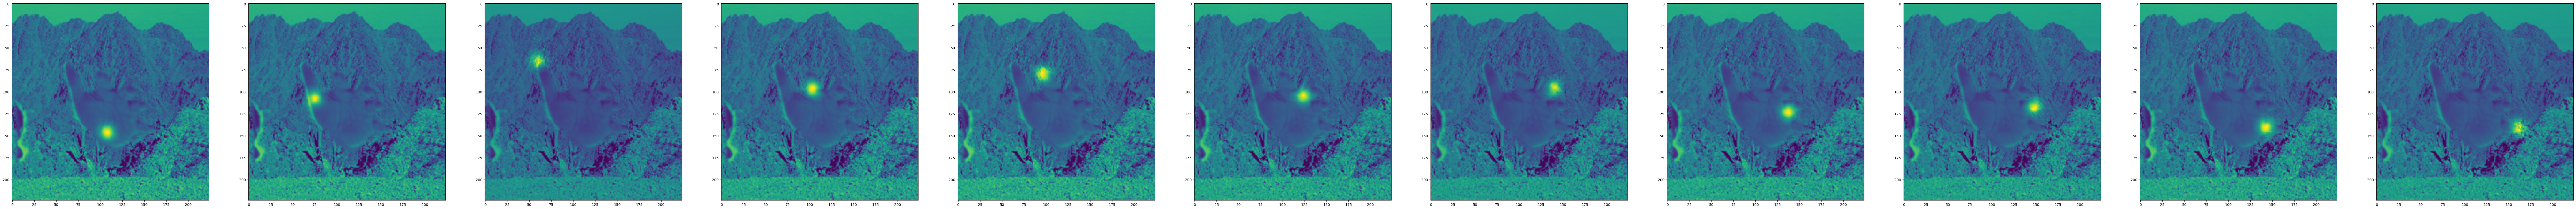

In [ ]:



plt.figure(figsize=[128, 128])
for k in range(N_KEYPOINTS):
  plt.subplot(1, N_KEYPOINTS, k+1)
  plt.imshow((data["image"][1][1])/4 + (data["heatmaps"][1][k]) )

[9135 6468 4238]


IndexError: ignored

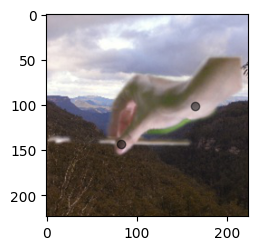

In [ ]:
# visualisasi training dataset
show_data(train_dataset, n_samples=4)

In [ ]:
# print(get_norm_params(train_dataloader))

In [12]:
# membuat eval dataset
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

In [ ]:
# visualisasi eval dataset
show_data(val_dataset, n_samples=8)

In [13]:
# membuat model U-Net
model = DepthwiseResidualUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

# membuat loss function
criterion = IoULoss()

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])

# membuat scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer, T_0=10, verbose=True, eta_min=0.01, T_mult=1
)

model.eval()

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-01.


DepthwiseResidualUNet(
  (conv_in): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (7): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (skip_1): ResiudalBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2)

In [14]:
# membuat trainer
trainer = Trainer(model, criterion, optimizer, config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9045867331, Val Loss=0.8230343868
Epoch 0.90: adjusting learning rate of group 0 to 2.9418e-01.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.3
    lr: 0.29418414751443134
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 2/1000, Train Loss=0.7120881126, Val Loss=0.7294653785
Epoch 0.71: adjusting learning rate of group 0 to 2.9639e-01.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.3
    lr: 0.296386789600749
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 3/1000, Train Loss=0.6543724768, Val Loss=0.6588792278
Epoch 0.65: adjusting learning rate of group 0 to 2.9695e-01.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.3
    lr: 0.2969467824510528
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0


KeyboardInterrupt: ignored

In [15]:
# save model
torch.save(model.state_dict(), "/content/fine")

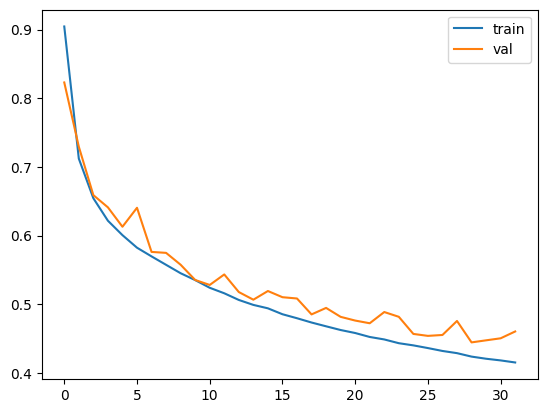

/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints


In [16]:
#visualisasi graphic training dan eval

plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()
print('/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints')

In [31]:
# Config testing
config = {
    "data_dir": "Dataset/",
    "model_path": "Epoch32",
    "test_batch_size": 4,
    "device": torch.device("cuda"),
}

In [32]:
# membuat dataset testing
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

In [18]:
import matplotlib
# load model
model_test = DepthwiseResidualUNet(3, 6)
model_test.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device("cuda"))
)


<All keys matched successfully>

In [24]:
image_raw = Image.open("00000024.jpg")
transform = transforms.Compose(
    [
        transforms.Resize(MODEL_IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
    ]
)
image_raw = transform(image_raw)
image_raw = image_raw[None,:, :, :]
image_raw.to("cuda")

tensor([[[[-2.0583, -2.0583, -2.0583,  ...,  0.1288,  0.0783,  0.0783],
          [-2.0751, -2.0583, -1.8900,  ...,  0.0952,  0.0615,  0.0615],
          [-2.0751, -2.0078, -1.5535,  ...,  0.1793,  0.0952,  0.0783],
          ...,
          [-1.9237,  0.0110,  0.8859,  ...,  0.3475,  0.4989,  0.6335],
          [-1.9237, -0.3086,  0.4485,  ...,  0.2802,  0.2970,  0.3139],
          [-2.0583, -1.7050, -1.4526,  ...,  0.1625,  0.2634,  0.2634]],

         [[-1.9721, -1.9721, -1.9889,  ..., -0.2445, -0.3116, -0.3451],
          [-1.9721, -1.9721, -1.8715,  ..., -0.2612, -0.3283, -0.3451],
          [-1.9386, -1.9218, -1.5528,  ..., -0.1774, -0.2612, -0.2948],
          ...,
          [-1.8882, -0.1941,  0.5271,  ...,  0.5774,  0.7451,  0.8961],
          [-1.8715, -0.4290,  0.1749,  ...,  0.4600,  0.4936,  0.5271],
          [-1.9218, -1.6870, -1.5696,  ...,  0.3426,  0.4432,  0.4600]],

         [[-1.6389, -1.6389, -1.6389,  ..., -0.3558, -0.4590, -0.5180],
          [-1.6094, -1.6094, -

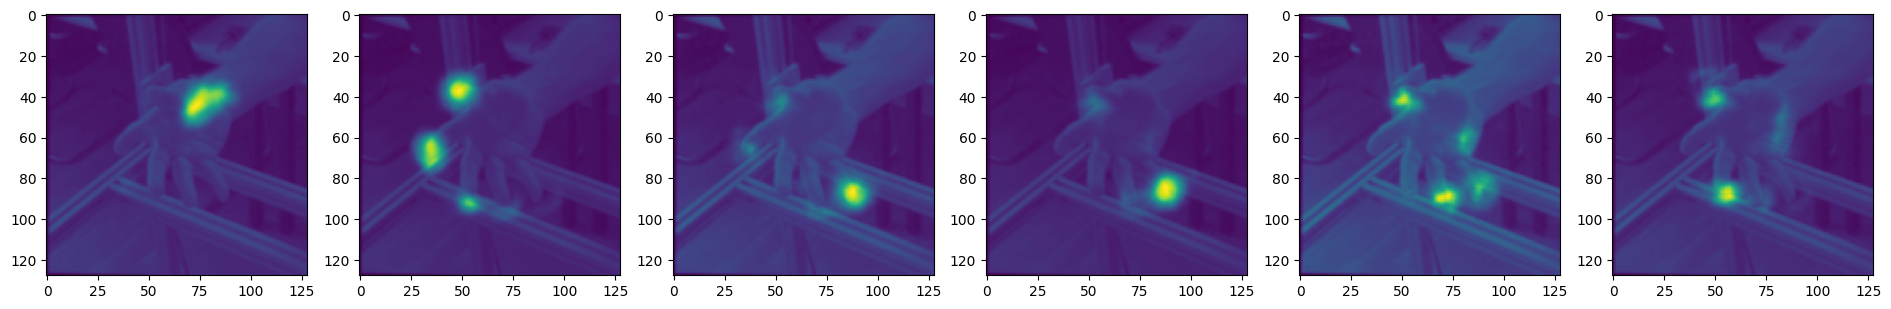

In [25]:
pred = model_test(image_raw)
pred = pred.detach().numpy()

plt.figure(figsize=[64, 64])
for i in range(len(pred[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /10) + (pred[0][i] * 2))

In [ ]:
model1 = model_test.conv_in(image_raw)
output_model1 = model1.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(16):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model1[0][i])

plt.show()

In [ ]:
model2 = model_test.conv_down1(model1)
output_model2 = model2.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model2[0][i])

plt.show()

In [ ]:
model3 = model_test.conv_down2(model_test.maxpool(model2))
output_model3= model3.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model3[0][i])

plt.show()

In [ ]:
model4 = model_test.conv_down3(model_test.maxpool(model3))
output_model4 = model4.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model4[0][i])

plt.show()

In [ ]:
model_new = model_test.conv_down4(model_test.maxpool(model4))
output_model_new = model_new.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model_new[0][i])

plt.show()

In [ ]:
model5 = model_test.conv_bottleneck(model_test.maxpool(model_new))
output_model5 = model5.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model5[0][i])

plt.show()

In [ ]:
model6 = model_test.conv_up1(torch.cat([model_test.upsample(model5), model_new], dim=1))
output_model6 = model6.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model6[0][i])

plt.show()


In [ ]:
model7 = model_test.conv_up2(torch.cat([model_test.upsample(model6), model4], dim=1))
output_model7 = model7.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model7[0][i])

plt.show()



In [ ]:
model8 = model_test.conv_up3(torch.cat([model_test.upsample(model7), model3], dim=1))
output_model8 = model8.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model8[0][i])

plt.show()



In [ ]:
model9 = model_test.conv_up4(torch.cat([model_test.upsample(model8), model2], dim=1))
output_model9 = model9.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model9[0][i])

plt.show()


In [ ]:
model10 = model_test.conv_out(model9)
output_model10 = model10.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model10[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /4) + (output_model10[0][i] * 2))

plt.show()

In [33]:
# melakukan testing
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 30/30 [00:01<00:00, 19.10it/s]


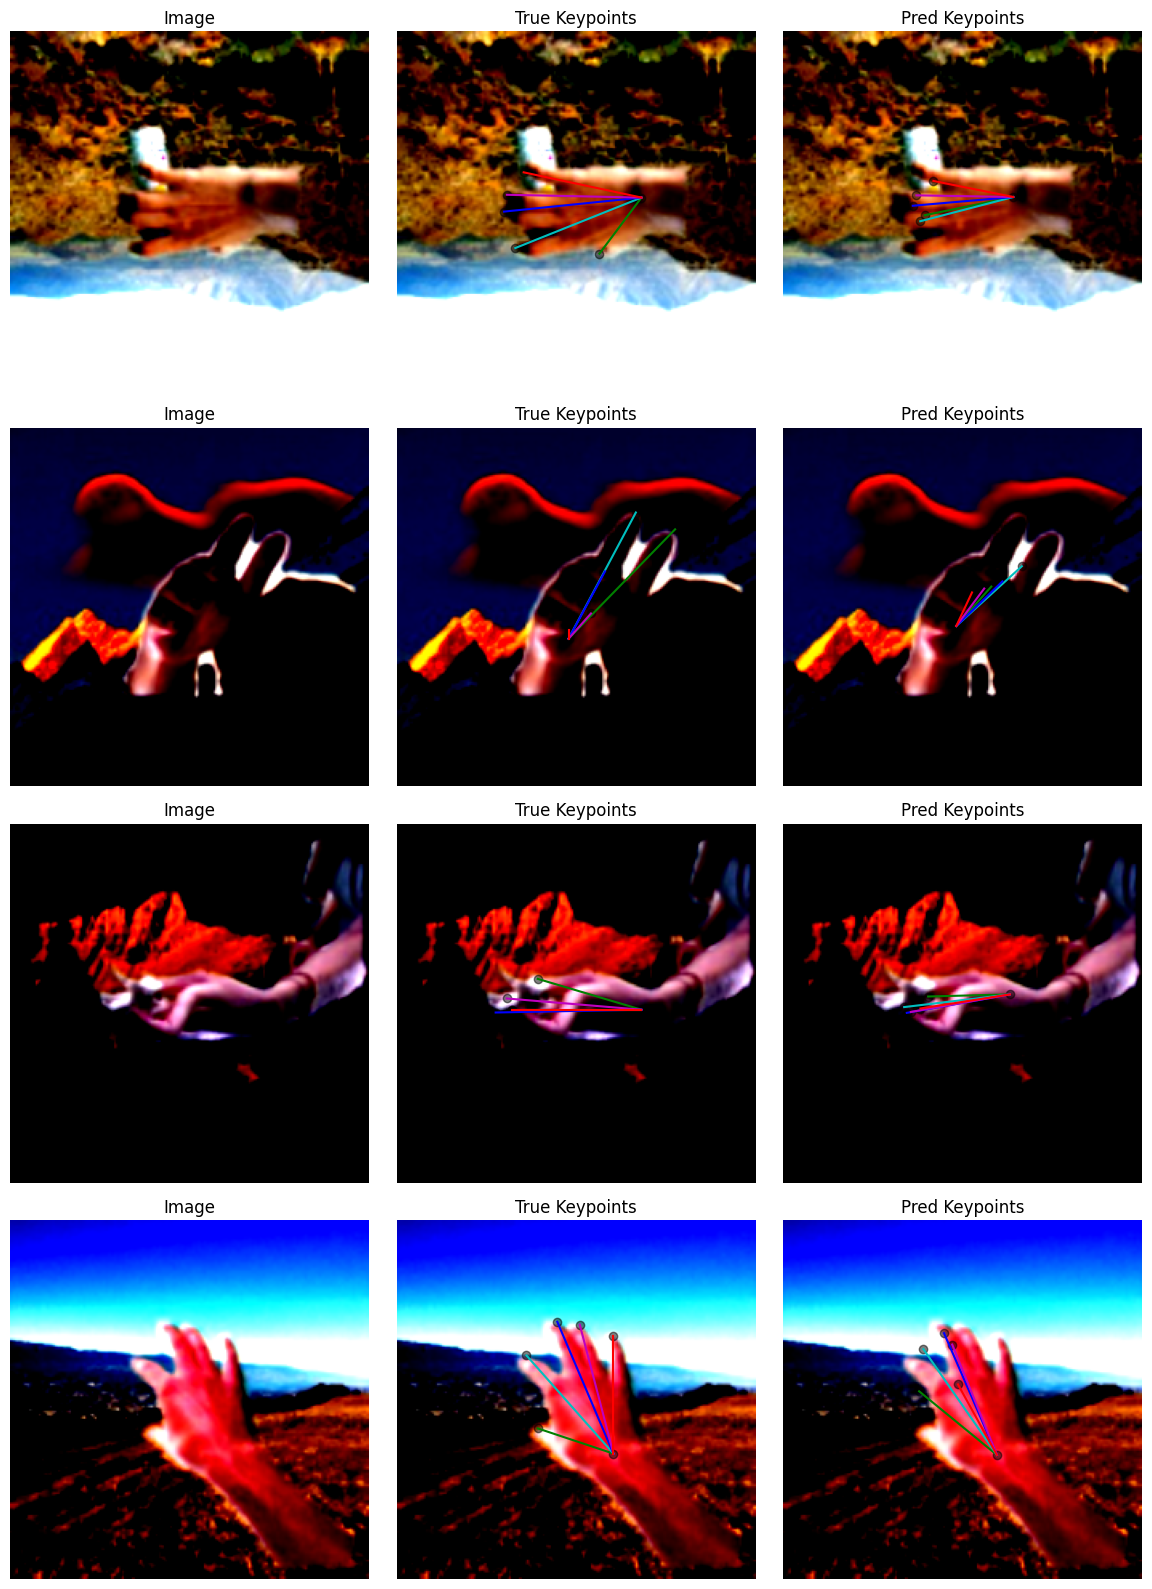

In [36]:
# visualisasi testing
for data in test_dataloader:
    show_batch_predictions(data, model)
    break